# Rossmann Sales Forescast

## 0.0. Imports

In [1]:
import pandas as pd
import inflection
import math
import datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import HTML
from IPython.display import Image

### 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container{width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
jupyter_settings()  

Populating the interactive namespace from numpy and matplotlib


### 0.2 Loading data
Font of dataset <a href="https://www.kaggle.com/c/rossmann-store-sales/data">Kaggle Rossmann Dataset</a> and dictionary about colomns

In [3]:
# loading datasets file
df_sales_raw = pd.read_csv("dataset/train.csv")
df_store_raw = pd.read_csv("dataset/store.csv")

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on='Store')

/home/python/PycharmProjects/Projects/rossmann_sales_forecast/venv_rossmann/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 1.0. Data Description

In [4]:
# copy data from original data
df1 = df_raw.copy()

### 1.1. Rename Columns

In [5]:
# get the name of columns
cols_old = df1.columns

See the documentation the <a href="https://inflection.readthedocs.io/en/latest/">Inflection Snakecase</a>

In [6]:
# transform snakecase with inflection
snakecase = lambda x: inflection.underscore(x)
cols_new = map(snakecase, cols_old)
# replace the columns
df1.columns = cols_new

### 1.2. Data Dimensions

In [7]:
# See the dimensions to know if we have a computing enough to run
print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of Columns: {df1.shape[1]}")

# In this case ok, my computer can run

Number of Rows: 1017209
Number of Columns: 18


### 1.3. Data Types 

In [8]:
# See types of each data and if will be necessary converting or not
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
# this case we have columns
# date = object (must be datetime)
# competition_open_since_year = float -> int
# competition_open_since_month = float -> int
# promo2_since_week = float -> int

# It's not possible convert to int because there are NaN, first let's fillna, after I will chage types
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [10]:
# only we will change it's data, because we must have date form to replace NaN the others columns

# date from object to datetime
df1['date'] = pd.to_datetime(df1.date).copy()

In [11]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
607763,874,5,2014-01-03,3726,468,1,0,0,1,a,a,3210.0,NaN,NaN,0,NaN,NaN,NaN
712581,882,2,2013-10-01,5922,784,1,0,0,0,a,a,30.0,4.0,2013.0,0,NaN,NaN,NaN
464469,300,7,2014-05-11,0,0,0,0,0,0,a,c,120.0,4.0,2009.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
815558,164,7,2013-06-30,0,0,0,0,0,0,a,a,1160.0,9.0,2005.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
51218,1044,2,2015-06-16,7437,939,1,1,0,0,c,a,240.0,4.0,2015.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4. Check NaN 

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5. Fillout NaN

#### 1.5.0 Review

    competition_distance
    If the competitors is nan, maybe there aren't competitors closer, others words, they are so far a way, well, 
    this case make a sence replace the value up the max value it's the same, but with values
        max() == 75860.0 I will replace to 200000.0

    competition_open_since_month
    competition_open_since_year
    promo2_since_week
    promo2_since_year
        This options above we will get from date the year, month and week to try the first solution, because
        there are many NaN and we will replace from date
        
    promo_interval
        If this columns contains any informations, it means that the store joined the promo2 else if this columns
        is empt it means that the store not joined the promo2, I will make comparison between 
        promo_interval and month from date, when if month contain in promo_interval it means promo2 == 1 else 
        promo2 == 0

#### 1.5.1. competition_distance

In [14]:
# Getting the max value from columns
max_value = df1['competition_distance'].max()
# calculate base on 200000.0 to automate % and rounded to up
val_repl_comp_dist = round(
    ((((200000.0 - max_value) / max_value) + 1) * max_value))
# replace the NaN to 200000.0 or defaut % up from max()
df1['competition_distance'] = df1['competition_distance'].fillna(
    val_repl_comp_dist)

In [15]:
# this way it's harder than fillna() and lesser performance
    # df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) == True else x)

#### 1.5.2. competition_open_since_month 
    competition_open_since_year
    promo2_since_week
    promo2_since_year

In [16]:
# Second Cycle
# the solution that Meigaron had it's not a ideal, because if you seeing the index == 522152 bellow
# see that imagine if competition had been NaN, the data is:
#  	 date    	day_of_week 	competition_open_since_month 	competition_open_since_year 	promo2_since_week 	promo2_since_year
# 2014-03-20  	    4       	           3.0              	         2014.0             	       3.0      	     2014
# as you see, all diferent from the real, but to first solution, we will be try, after we will try other way

# see at bellow code
#df1[['date', 'day_of_week', 'competition_open_since_month', 
#    'competition_open_since_year', 'promo2_since_week', 
#    'promo2_since_year']][df1.index == 522152]

In [17]:
# replacing the NaN with day, week, month and year from date, it's suppose to date
# is beggining the competition between sotores

# competition_open_since_month
df1['competition_open_since_month'] = df1[
    'competition_open_since_month'].fillna(df1.date.dt.month)

# competition_open_since_year
df1['competition_open_since_year'] = df1[
    'competition_open_since_year'].fillna(df1.date.dt.year)

# promo2_since_week
df1['promo2_since_week'] = df1['promo2_since_week'].fillna(
    df1.date.dt.dayofweek)

# promo2_since_year
df1['promo2_since_year'] = df1['promo2_since_year'].fillna(
    df1.date.dt.year)

#### 1.5.3. promo_interval

In [18]:
# this map is to replace number to your value, exemple, 2:'Feb' where has the number 2 will be replace to 'Feb'
month_map = {
    1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
    7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'
}
# replace number to month name with map()
df1['month_map'] = df1['date'].dt.month.map(month_map)

# replace the NaN to zero "0" at the column promo_interval
df1['promo_interval'].fillna(0, inplace=True)

# run each line and it's verify if month_map contains in promo_interval
# return 1 to new columns ['is_promo']
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in
    x['promo_interval'].split(',') else 0, axis=1)

In [19]:
# Second Cycle

# df1.sample(10)
# first of all we will replace the promo_interval to number or..
# create a new column with month name and compare

# this head will be to view a comparation before than after alteration and see if run
#df1.head(20)

# see if the value in month_map contains in promo_interval if is true than replace promo2 to 1 else
# replace to 0
#df1['is_promo'] = df1[['promo2', 'promo_interval', 'month_map']].apply(
#    lambda x: 1 if x['promo2'] == 1 else 1 if x['month_map'] in str(x['promo_interval']).split(',') else 0, axis=1)

# this is the next cycle, because I think that the Meigaron Ideia it's not right, but we will run the way
# from him and after run this solution and compere the score between them.
#df1[['date', 'promo', 'promo2', 'promo2_since_year', 
#     'promo_interval', 'month_map', 'is_promo']][df1.index == 12]

### 1.6. Change Types

In [20]:
# convert object to integer
df1['competition_open_since_month'] = df1[
    'competition_open_since_month'].astype(int)

# convert object to integer
df1['competition_open_since_year'] = df1[
    'competition_open_since_year'].astype(int)

# convert object to integer
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

# convert object to integer
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.7. Descriptive Statistical

In [21]:
# Slicing datatype by numerical and categorical data, first of all we need see dtypes

# to show kind of dtypes
df1.dtypes.value_counts()

int64             13
object             5
datetime64[ns]     1
float64            1
dtype: int64

In [22]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(
    exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.7.1 Numerical

In [23]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


In [24]:
# Central Tendency - mean, median
ct_mean = pd.DataFrame(num_attributes.mean())
ct_median = pd.DataFrame(num_attributes.median())

In [25]:
# Dispersion - std, min, max, range, skew, kurtosis

d_std = pd.DataFrame(num_attributes.std())
d_min = pd.DataFrame(num_attributes.min())
d_max = pd.DataFrame(num_attributes.max())
d_range = pd.DataFrame(d_max - d_min)
d_skew = pd.DataFrame(num_attributes.skew())
d_kurtosis = pd.DataFrame(num_attributes.kurtosis())

In [26]:
# Concatenation Metrics
metrics = pd.concat(
    [d_min, d_max, d_range, ct_mean, ct_median, d_std, d_skew, d_kurtosis],
    axis=1).reset_index()

metrics.columns = [
    'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew',
    'kurtosis'
]

In [27]:
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.652996,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515593,-7.235657,124.071304


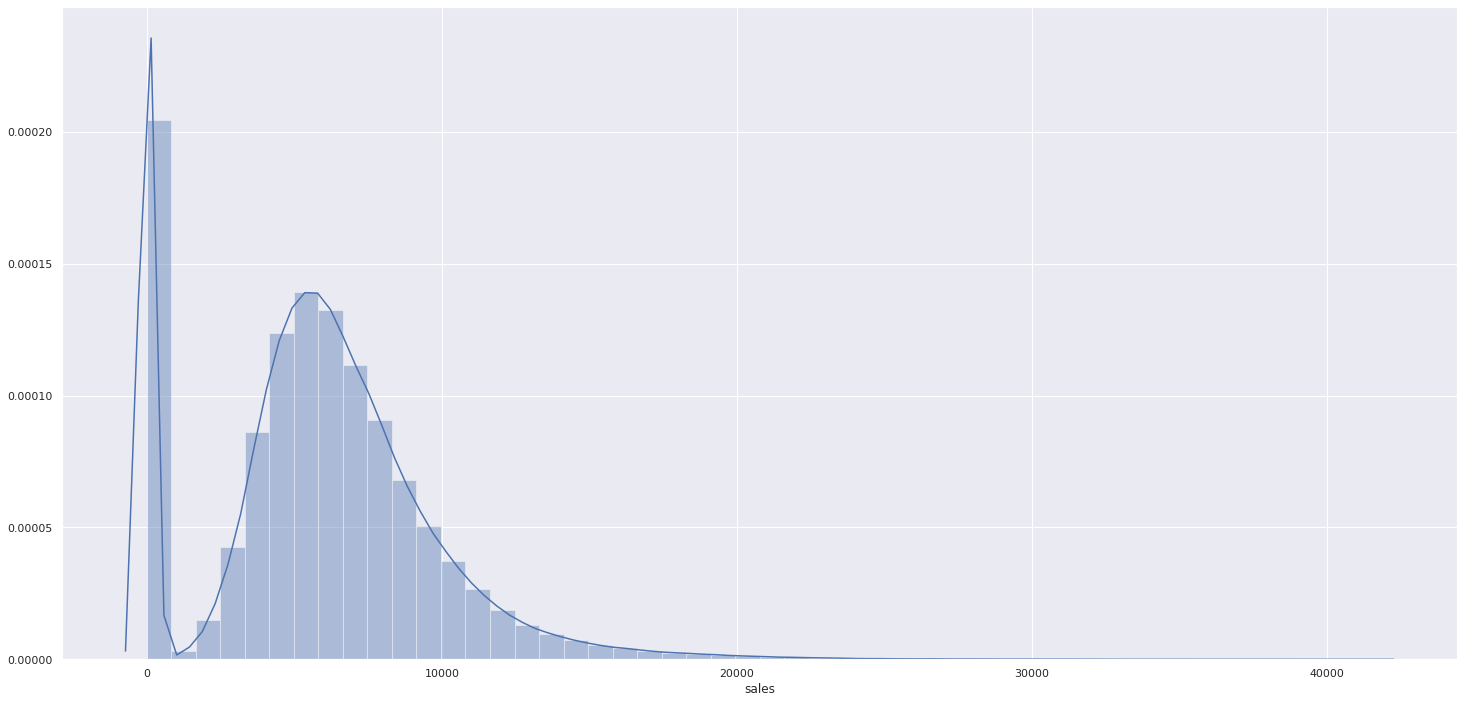

In [28]:
# Sales Distribution
sns.distplot(df1['sales'])

# as you see the most of volum of sales it's closer of zero, why?

#### 1.7.2 Categorical

In [29]:
cat_attributes.describe(include='all')

,state_holiday,store_type,assortment,promo_interval,month_map
count,1017209,1017209,1017209,1017209,1017209
unique,5,4,3,4,12
top,0,a,a,0,May
freq,855087,551627,537445,508031,103695


In [30]:
#sns.boxplot(x='state_holiday', y='sales', data=df1)
# as you see that's impossible understand something, probably because the range it's so long and there are
# a "0" in the state_holiday, it's possible in that state_holiday==0 is close store, let's get off the 0

In [31]:
aux_filt_sh = df1[(df1['state_holiday'] != 0)&(df1['state_holiday'] != '0')]                 

In [32]:
#sns.boxplot(x='state_holiday', y='sales', data=aux_filt_sh)

# this case it's not solve the problem because the sales it's most closer at '0', in this case I think one solution is
# do filter when take above '0' otherwords up of zero it's like a (sale > zero), let's try

count of each


a    694
b    145
c     71
Name: state_holiday, dtype: int64

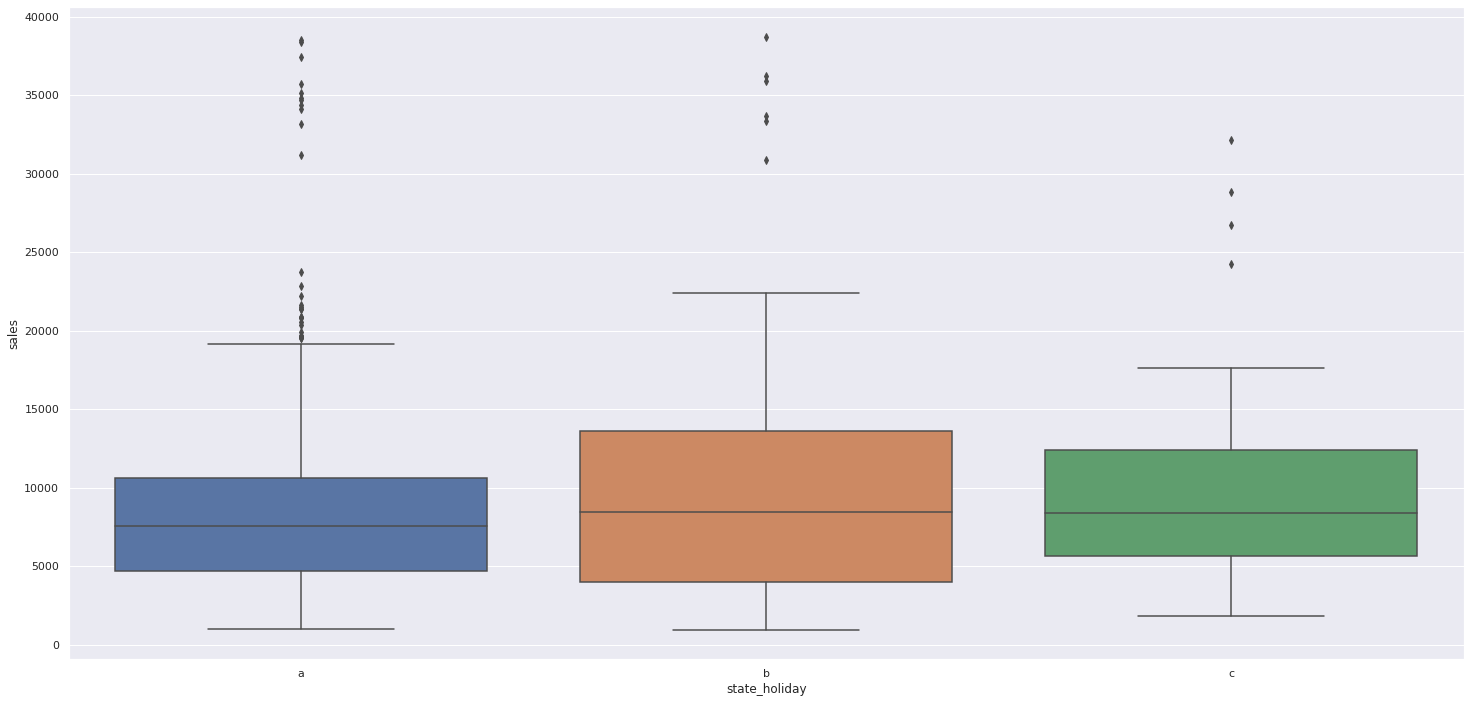

In [33]:
sns.boxplot(x='state_holiday', y='sales', data=aux_filt_sh[aux_filt_sh.sales > 0])
print('count of each')
aux_filt_sh['state_holiday'][aux_filt_sh.sales > 0].value_counts()

# OK! that's right now, but let's compare the others categorical columns

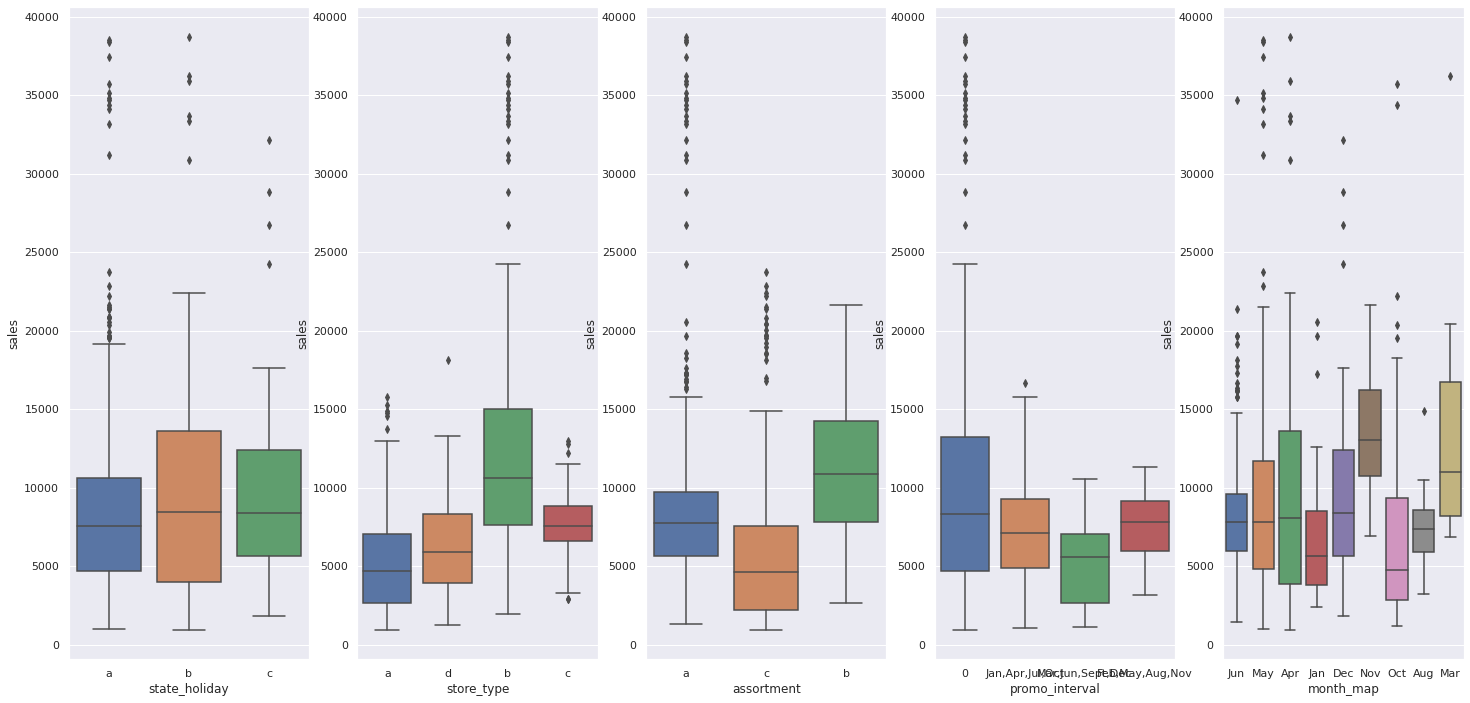

In [34]:
# plotting filtering only holidays, otherwords, nothing a normal days and sales up than zero (sales > 0)
cont = 1
for cat in cat_attributes.head():
    plt.subplot(1, cat_attributes.shape[1], cont)
    sns.boxplot(x=cat, y='sales', data=aux_filt_sh[aux_filt_sh.sales > 0])
    cont += 1

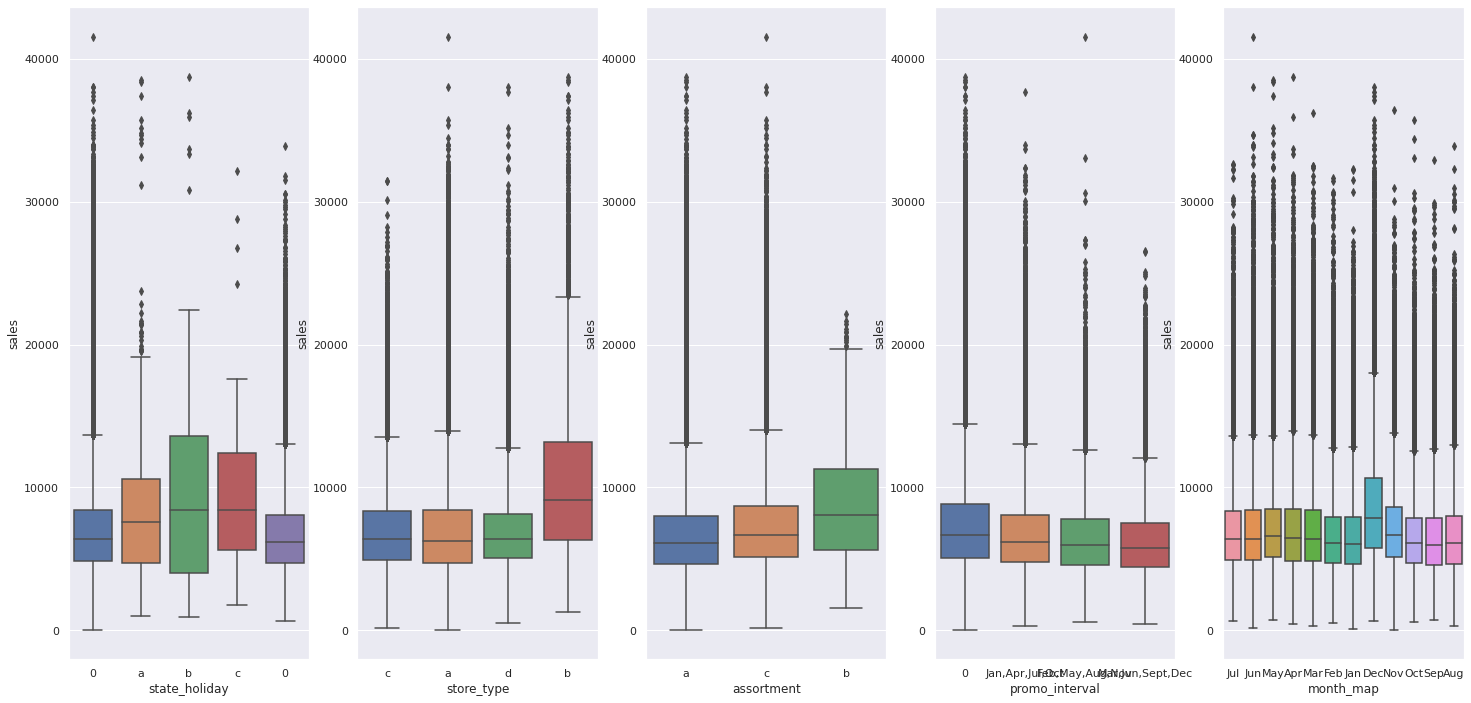

In [35]:
# Let's see bellow the total data to compare with only holidays above ^
cont = 1
for cat in cat_attributes.head():
    plt.subplot(1, cat_attributes.shape[1], cont)
    sns.boxplot(x=cat, y='sales', data=df1[df1['sales'] > 0])
    cont += 1

## 2.0. Feature Engineering

### 2.1. Hypothesis Mind Map

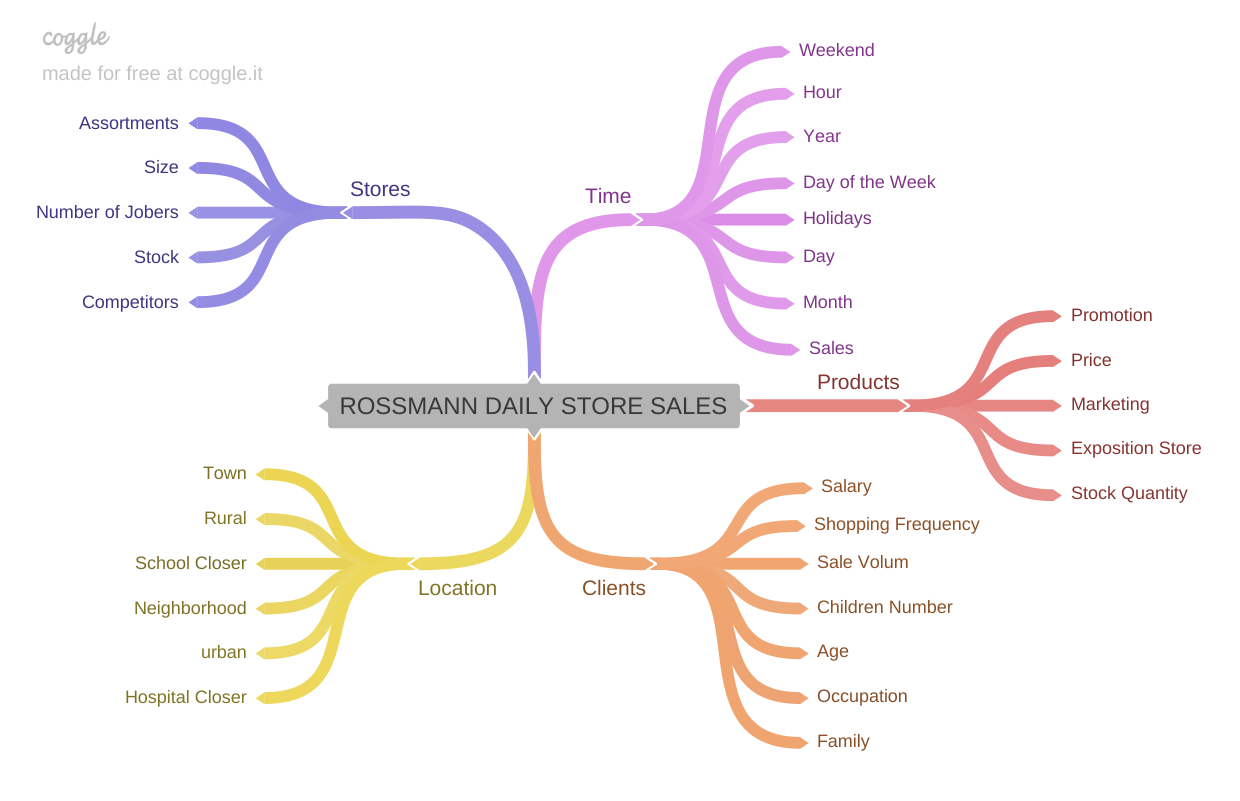

In [36]:
# MindMap to possible hyphotesis list
# Importing Mid Map builded in the coggle site
Image('img/rossamann_mid_map_hypothesis.png')

# To build a Hyphotesis MindMap you will must three asks
# 1-> Fenomeno | 2->Agents or Entities | 3->Attributes

### 2.2. Building Hypothesis List

#### 2.2.1. Store

<input type="checkbox" checked> **_1.** It's supposed to more assortments more sale

<input type="checkbox">**_2.** It's supposed to how much bigger store, more sale

<input type="checkbox">**_3.** It's supposed to how much more a numbers of employers, more sale

<input type="checkbox">**_4.** It's supposed how much more stock more sale

<input type="checkbox" checked>**_5.** It's supposed to how more distance from competitors, more sale



#### 2.2.2. Products

<input type="checkbox"> **1.** It's supposed to how much more investments in marketing, more sale

<input type="checkbox"> **2.** It's supposed to how much exposition products, sale more

<input type="checkbox"> **3.** It's supposed to how much product lesser price, more sale

<input type="checkbox"> **4.** It's supposed to how much more discounts or agressive promotion, more sale

#### 2.2.3. Time

<input type="checkbox" checked> **1.** It's supposed to on the weekend you will sales less

<input type="checkbox"> **2.** It's supposed to on the night sale more

<input type="checkbox"> **3.** It's supposed to there are a cycle each year that sale more and less

<input type="checkbox"> **4.** It's supposed to on the monday sale more

<input type="checkbox"> **5.** It's supposed to on the holidays sale less

<input type="checkbox"> **6.** It's supposed to on days that the clients recieve the salary, sale more

<input type="checkbox"> **7.** It's supposed to on the months in the winter sale more

<input type="checkbox"> **8.** It's supposed to on the end's month sale more because the "on-sale" promotion

<input type="checkbox" checked> **9.** It's supposed to the store open in the christmas holiday sale more

<input type="checkbox" checked> **10.** It's supposed to how much older the store, more sale

<input type="checkbox" checked> **11.** It's supposed to sale more in the second semester

<input type="checkbox" checked> **12.** It's supposed to sale more after day 10 from each month

<input type="checkbox" checked> **13.** It's supposed to holidays school sale less

<input type="checkbox" checked> **14.** It's supposed to how much more long time competitors, more sale

<input type="checkbox" checked> **15.** It's supposed to how much longer time promotion active, more sale

<input type="checkbox" checked> **16.** It's supposed to how much days in promotion, more sale

<input type="checkbox" checked> **17.** It's supposed to how much consecutives promotion, more sale

#### 2.2.3. Clients

<input type="checkbox"> **1.** It's Supposed to how much bigger salary less sale

<input type="checkbox"> **2.** It's supposed to how much more class "C", more sale <a href="https://www.ictq.com.br/varejo-farmaceutico/405-perfil-do-consumidor-de-medicamentos">Article Font Link</a> 

<input type="checkbox"> **3.** It's supposed to female buy more than male <a href="https://www.ictq.com.br/varejo-farmaceutico/405-perfil-do-consumidor-de-medicamentos">Article Font Link</a>

<input type="checkbox"> **4.** It's supposed to how much more frequency more sale

<input type="checkbox"> **5.** It's supposed to how much more mean ticket, more sale

<input type="checkbox"> **6.** It's supposed to how much more volum sale, more sale

<input type="checkbox"> **7.** It's supposed to how children, more sale

<input type="checkbox"> **8.** It's supposed to how much more age, more sale

<input type="checkbox"> **9.** It's supposed to how much more simple occupation client, more sale

<input type="checkbox"> **10.** It's supposed to how much more degree graduation, less sale <a href="https://www.ictq.com.br/varejo-farmaceutico/405-perfil-do-consumidor-de-medicamentos">Article Font Link</a>

<input type="checkbox"> **11.** It's supposed to how much more members from family, more sale

#### 2.2.5. Location

<input type="checkbox"> **1.** It's supposed to store location is in a town, more sale

<input type="checkbox"> **2.** It's supposed to how much closer store by hospital, more sale

<input type="checkbox"> **3.** It's supposed to how much closer school, more sale

<input type="checkbox"> **4.** It's supposed to how much the neighborhood closer by town, more sale

<input type="checkbox"> **5.** It's supposed to hurban store saler more than rural

### 2.3. Priority Hypothesis List

<input type="checkbox" checked> **1.** It's supposed to stores that has more assortments more sale

<input type="checkbox" checked> **2.** It's supposed to how less competitors closer, more sale

<input type="checkbox" checked> **3.** It's supposed to how much more long time competitors, more sale

<input type="checkbox"> **4** It's supposed to how much longer time promotion active, more sale

<input type="checkbox"> **5.** It's supposed to how much days in promotion, more sale

<input type="checkbox"> **6.** It's supposed to how much consecutives promotion, more sale

<input type="checkbox"> **7.** It's supposed to the store open in the christmas holiday sale more

<input type="checkbox"> **8.** It's supposed to how much older the store, more sale

<input type="checkbox"> **9.** It's supposed to sale more in the second semester

<input type="checkbox"> **10.** It's supposed to sale more after day 10 from each month

<input type="checkbox"> **11.** It's supposed to on the weekend you will sales less

<input type="checkbox"> **12.** It's supposed to holidays school sale less

### 2.4. Feature Engineering

#### 2.4.1 Derivates Features

In [37]:
# New dataframe to build features
df2 = df1.copy()

# year
df2['year'] = df1['date'].dt.year

# month
df2['month'] = df1['date'].dt.month

# day
df2['day'] = df1['date'].dt.day

# week of year
df2['week_of_year'] = df1['date'].dt.weekofyear

# year week
df2['year_week'] = df1['date'].dt.strftime('%Y-%W')

In [38]:
# competition since
df2['competition_since'] = df1.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df1['date'] - df2['competition_since'])/30).apply( lambda x: x.days )

In [39]:
# promo since
df2['promo_since'] = df1['promo2_since_year'].astype( str 
    ) +'-'+ df1['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply(
    lambda x: datetime.datetime.strptime( 
    x +'-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))

# since time week in promotion
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days ).astype( int )

In [40]:
# assortments
df2['assortment'] = df1['assortment'].map({'a':'basic', 'b':'extra', 'c':'extended'})

In [41]:
# state holiday
map = {
    '0':'regular_day',
    'a':'public_holiday',
    'b':'easter_holiday',
    'c':'christmas'
}

df2['state_holiday'] = df1['state_holiday'].map(map)

In [42]:
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
558650,821,7,2014-02-16,0,0,0,0,NaN,0,a,basic,1700.0,9,2009,0,6,2014,0,Feb,0,2014,2,16,7,2014-06,2009-09-01,54,2014-02-03,1
422554,755,3,2014-06-18,10818,893,1,1,regular_day,0,d,extended,13130.0,12,2003,0,2,2014,0,Jun,0,2014,6,18,25,2014-24,2003-12-01,128,2014-01-06,23
282538,408,3,2014-11-12,4232,406,1,1,regular_day,0,c,basic,1560.0,11,2014,1,45,2009,"Feb,May,Aug,Nov",Nov,1,2014,11,12,46,2014-45,2014-11-01,0,2009-11-02,262
44357,873,1,2015-06-22,3802,475,1,0,regular_day,0,a,basic,2040.0,11,2008,0,0,2015,0,Jun,0,2015,6,22,26,2015-25,2008-11-01,80,2014-12-22,26
433277,328,7,2014-06-08,0,0,0,0,regular_day,0,a,basic,3130.0,7,2002,0,6,2014,0,Jun,0,2014,6,8,23,2014-22,2002-07-01,145,2014-02-03,17


## 3.0. Variables Filters

In [43]:
# copy from df2
df3 = df2.copy()

<h6>Business Restriction</h6>
<table align="left" style="width:100%">
    <tr>
        <th>Columns</th>
        <th>Restriction</th>
        <th>Doing Now</th>
        <th>Future Solution</th>
        <th>--------</th>
    </tr>
    <tr>
        <td>Customers</td>
        <td>We don't have this data on the production</td>
        <td>Left out</td>
        <td>Make a prediction to get the volue</td>
        <td>--------</td>
    </tr>
    <tr>
        <td>Open</td>
        <td>Filtered only one information</td>
        <td>Left out</td>
        <td>--------</td>
        <td>--------</td>
    </tr>
    <tr>
        <td>Promo Interval</td>
        <td>Derivated</td>
        <td>Left out</td>
        <td>--------</td>
        <td>--------</td>
    </tr>
    <tr>
        <td>Month Map</td>
        <td>Derivated</td>
        <td>Left out</td>
        <td>--------</td>
        <td>--------</td>
    </tr>
</table>

### 3.1 Lines Filters

In [44]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2. Columns Selection

In [45]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [46]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 4.0. Data Exploratory

<li>Gain Business Experience</li>
<li>Hypothesis Validation (Insights)</li>
<li>Variables Perception to Modeling</li>

<h4>Three types of Exploratory Data Analysis</h4>
<li>Univariate Analysis</li>
<li>Bivariate Analysis</li>
<li>Multivariate Analysis</li>

In [47]:
# Copy from Data Frame df3
df4 = df3.copy()

### 4.1. Univariate Analysis

#### 4.1.1 Response Variable

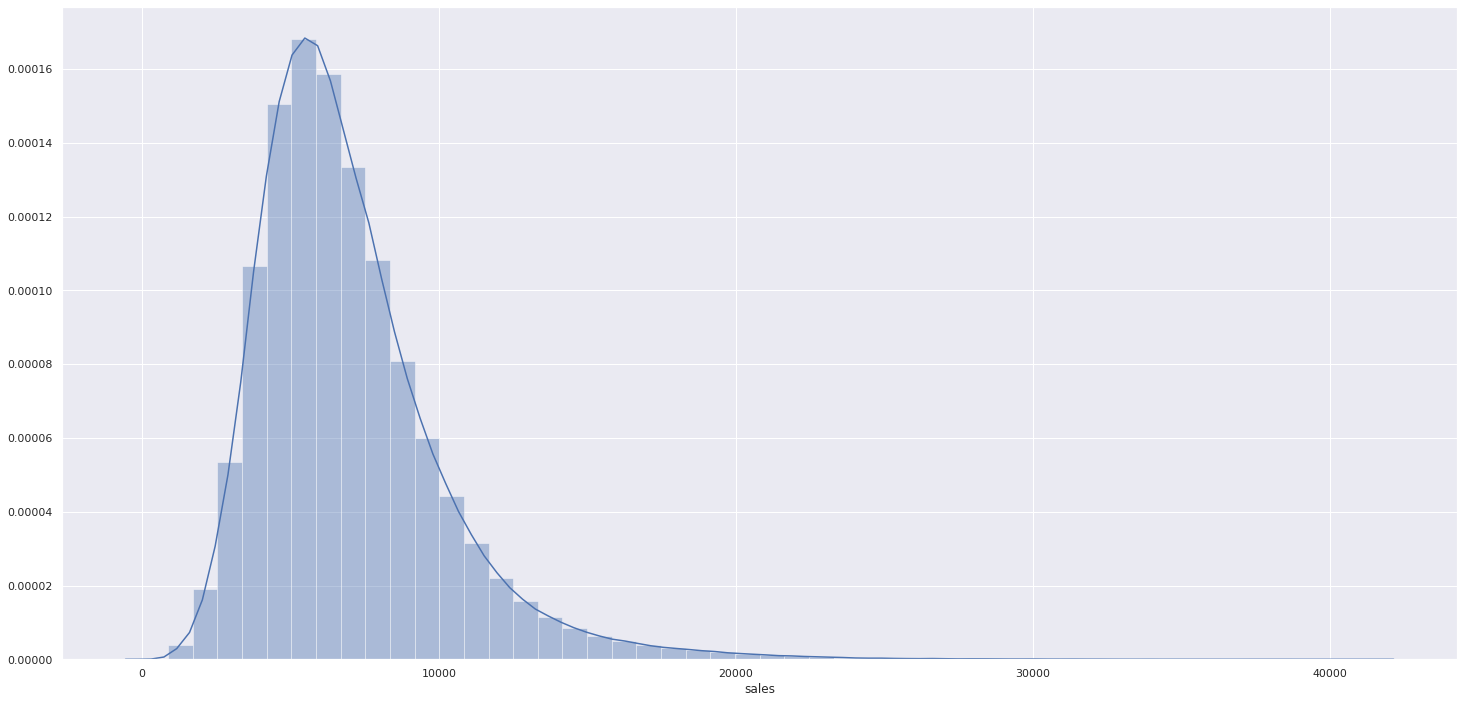

In [48]:
sns.distplot(df4['sales'])

#### 4.1.2 Numerical Variable

This is the original data df1

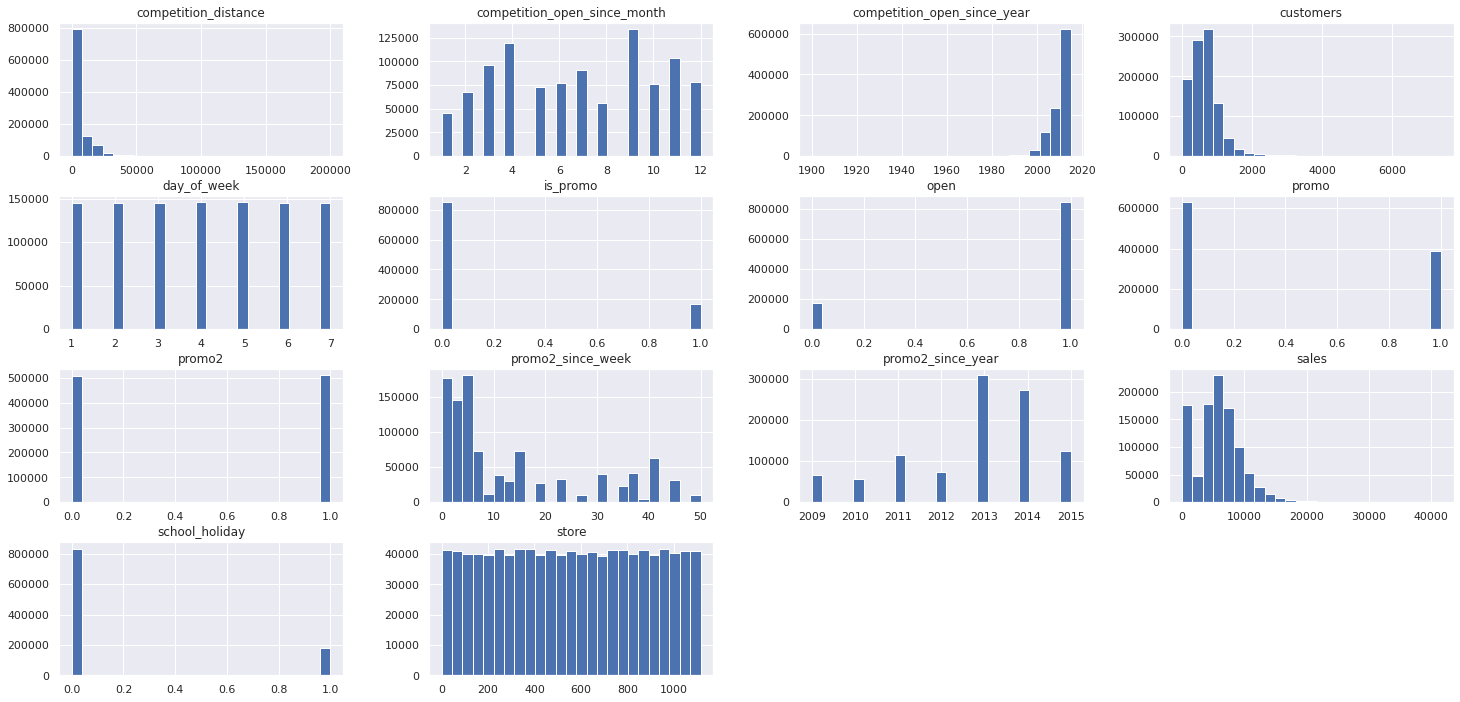

In [49]:
# atributes from df1
num_attributes.hist(bins=25);

This is the filtered data by sale > 0 and store opened

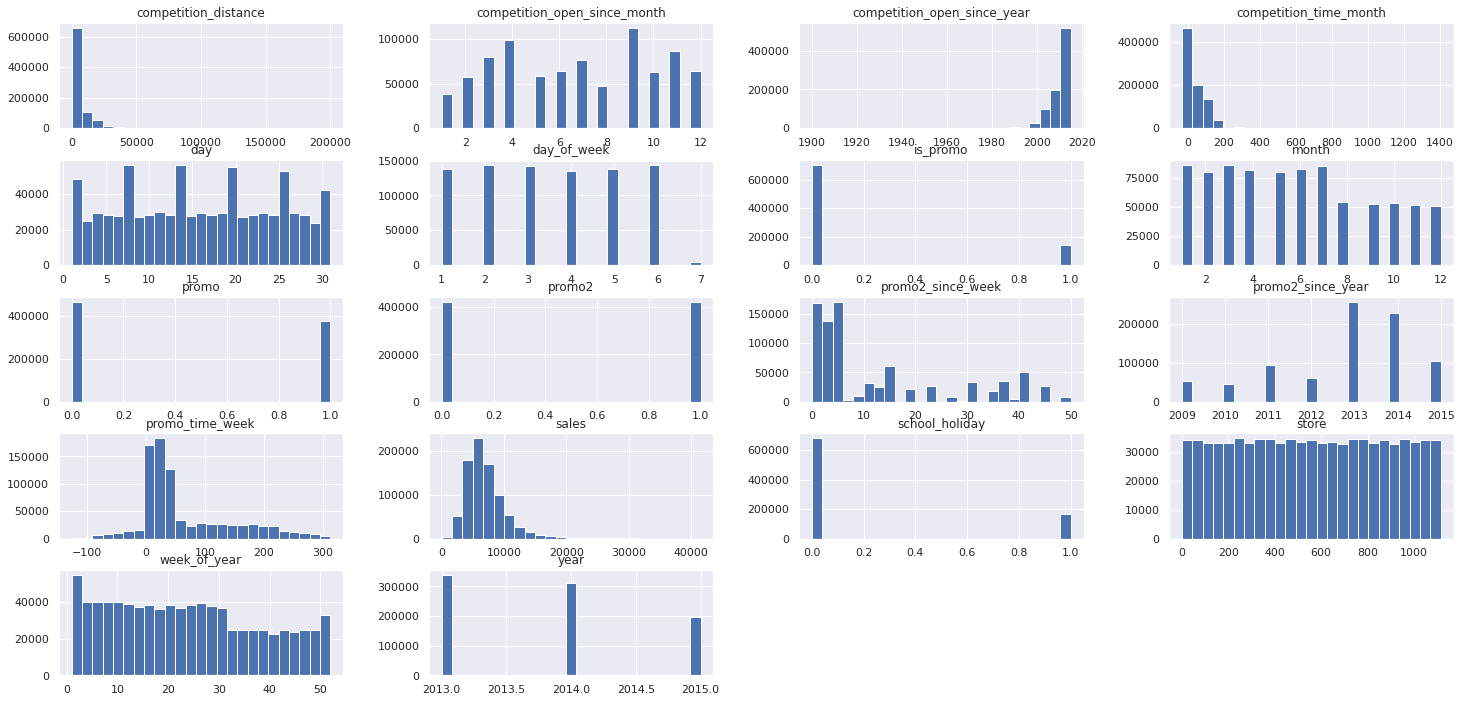

In [50]:
# atributes from df4
df4.select_dtypes(exclude='object').hist(bins=25);

#### 4.1.3 Categorical Variable

<p>The Christmas really hight sale, but not highter than public holidays</p>
<p>The Store Type 'd' has most sale than, but we don't have the information what kind is this letters yet</p>
<p>The assortment 'basic' and 'extended' it's closer in count and sales while the extra it's very down sale comparing with others</p>

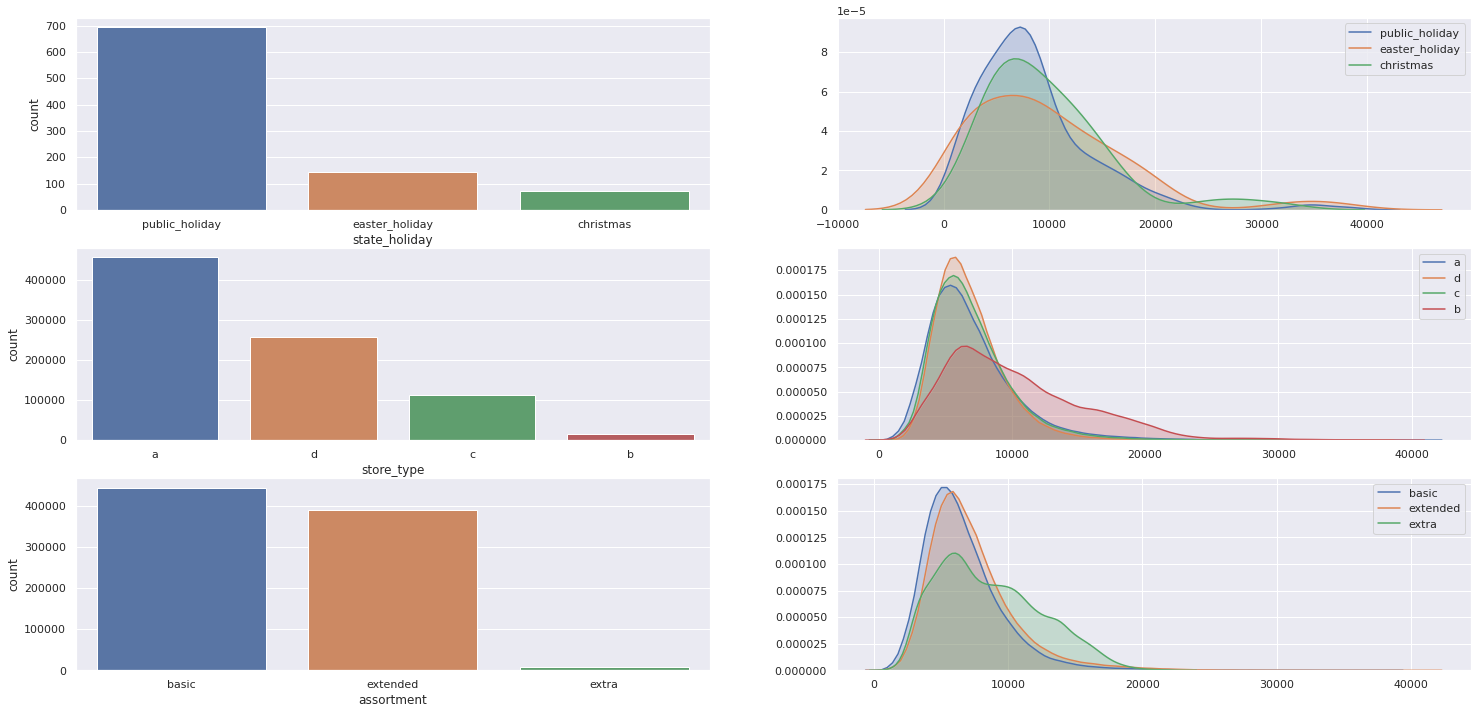

In [51]:
# state holidays - only holidays
plt.subplot(3,2,1)
holidays = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(holidays['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True);

# story_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'], order=['a', 'd', 'c', 'b']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True);

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

### 4.2. Bivariate Analysis

#### 4.2.1 Hypothesis Answers

In [52]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

##### 1. It's supposed to stores that has more assortments more sale
***False** stores with MOST ASSORTMENT sale MORE

As you see, it's TRUE, the EXTRA assortment sale more than extended and basic in mean per store, otherwords, sum sales divided per store numbers has a mean

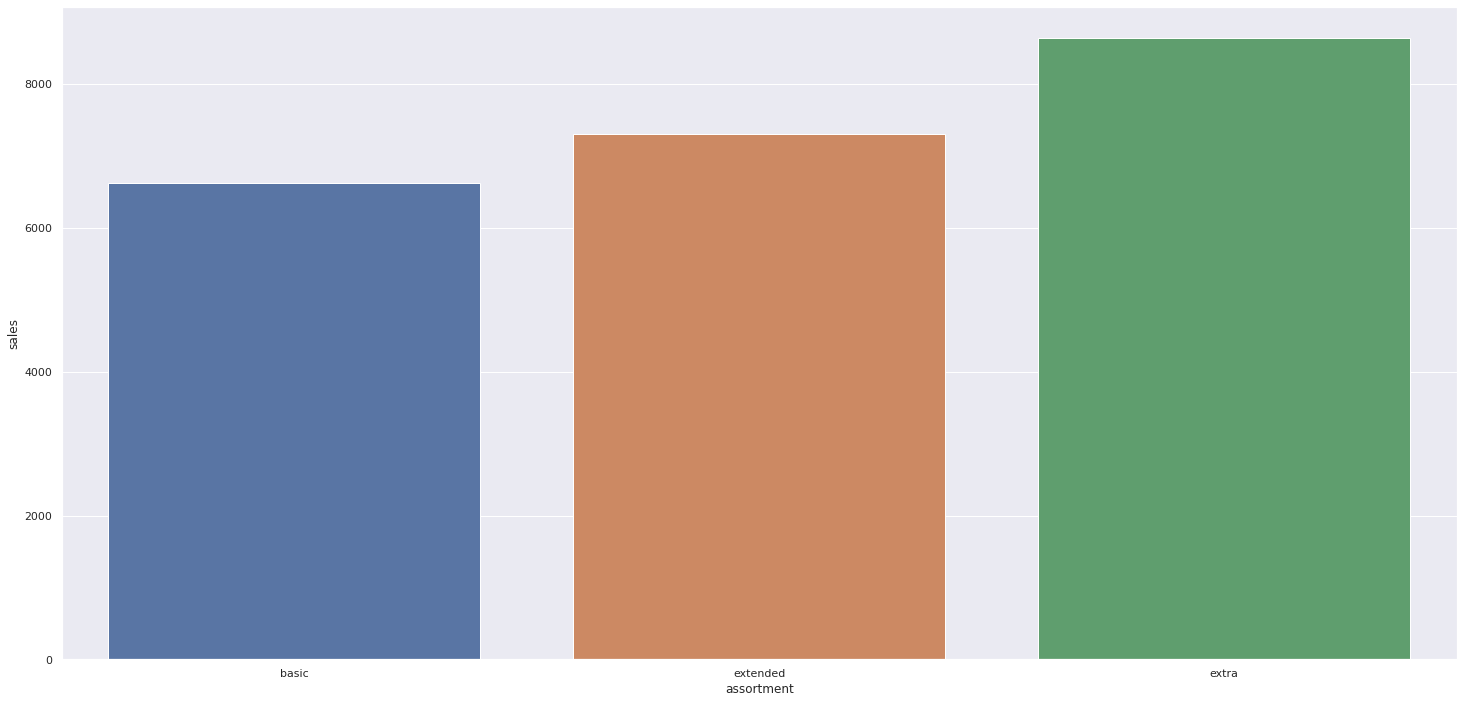

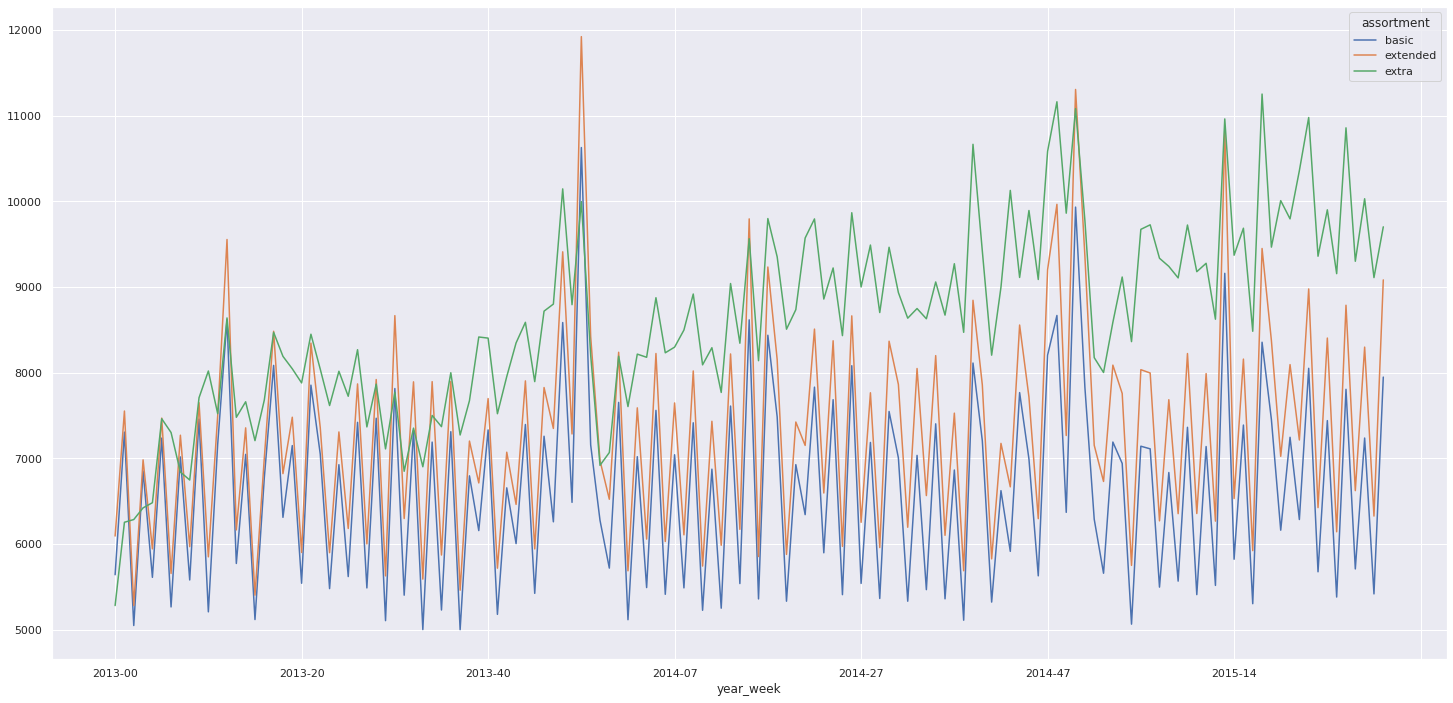

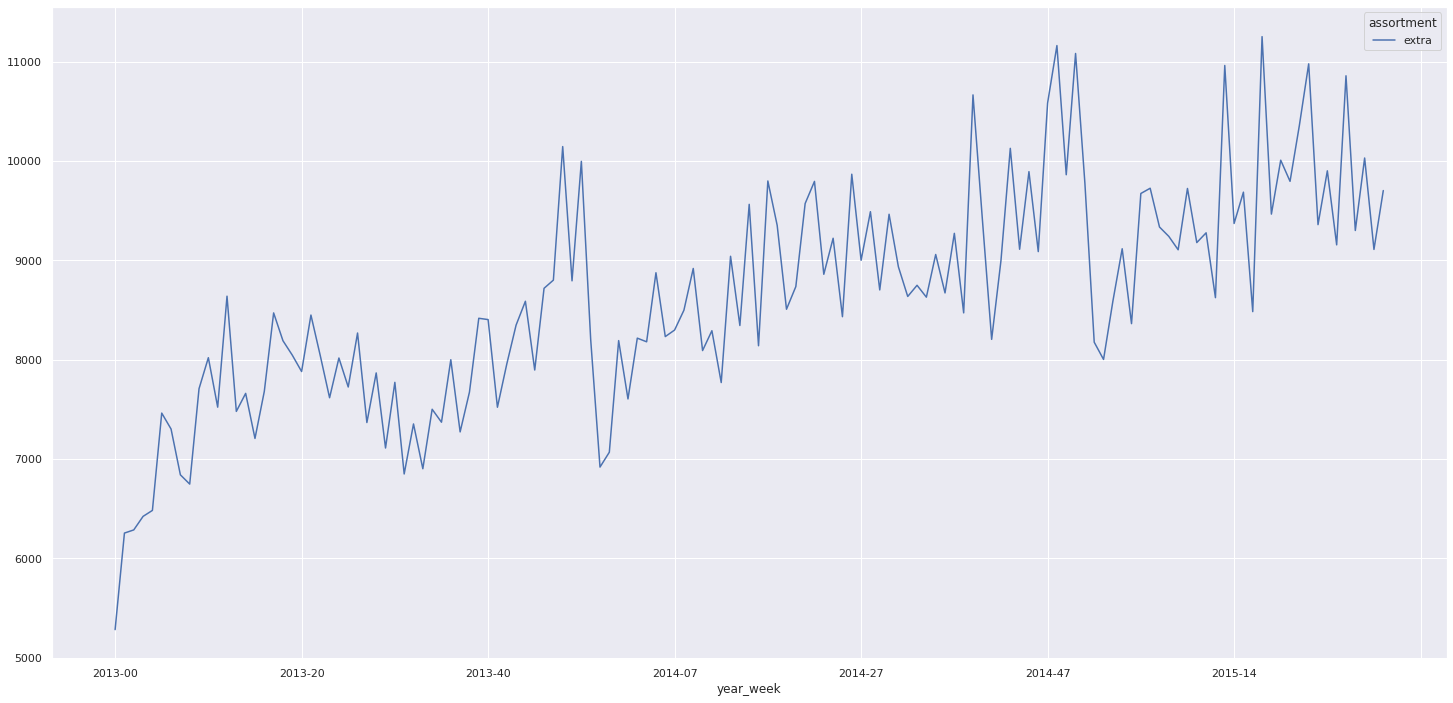

In [53]:
aux_ass_mean = df4[['assortment', 'sales']].groupby('assortment', ).mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux_ass_mean);

aux_mean_week = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()
aux_mean_week.pivot(index='year_week', columns='assortment', values='sales').plot();

aux_m_w_extra = aux_mean_week[aux_mean_week['assortment'] == 'extra'].groupby(['year_week', 'assortment']).mean().reset_index()
aux_m_w_extra.pivot(index='year_week', columns='assortment', values='sales').plot();

##### 2. It's supposed to how more distance from competitors, more sale
**False** stores with MORE DISTANCE from competitors, sale more, in FACT neither MORE or LESS

In [61]:
# df4['competition_distance'][df4['competition_distance'] < 100000].max()
# The real max() at the column competition_distance is 75860, otherwise the value that
# I can do bins is ultil round max() arange( 0,76000,1000 ) start zero until 80k step by 1k

75860.0

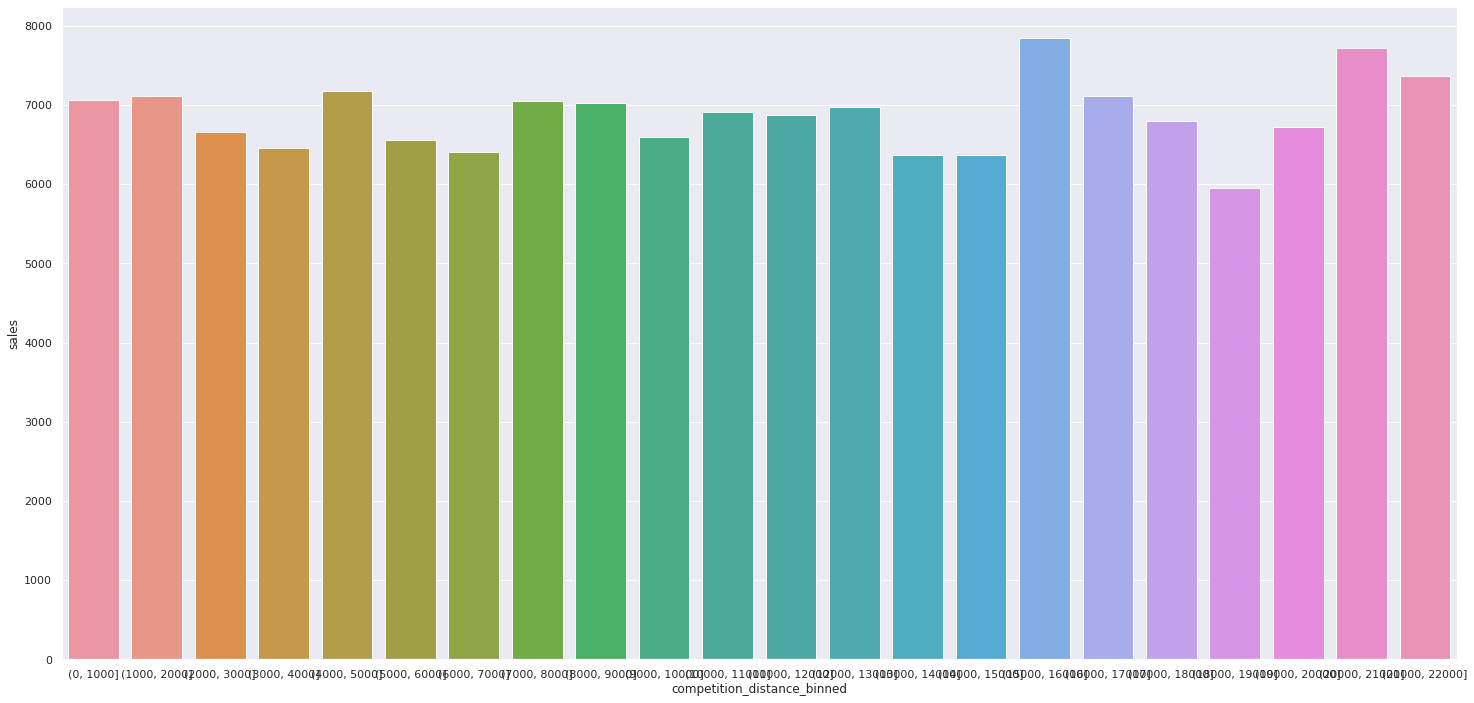

In [173]:
print(com_d_mean['competition_distance_binned'].value_counts(
    )[com_d_mean['competition_distance_binned'].value_counts() > 5])
# as you see, there are so much more stores closer from competitors than far, 
# in this case get the mean it's better, upper than 5 it's better 
# where there are more counts ultil 23k

com_d_mean = df4[['competition_distance', 'sales']].groupby(
    'competition_distance').mean().reset_index()
bins = list(np.arange(0, 23000, 1000))
com_d_mean['competition_distance_binned'] = pd.cut(com_d_mean['competition_distance'], bins=bins)
com_d_mean_binned = com_d_mean[['competition_distance_binned', 'sales']].groupby(
    'competition_distance_binned').mean().reset_index()

sns.barplot(x='competition_distance_binned', y='sales', data=com_d_mean_binned);
# as you see it's False, because the aren't a comportament like a linear growth

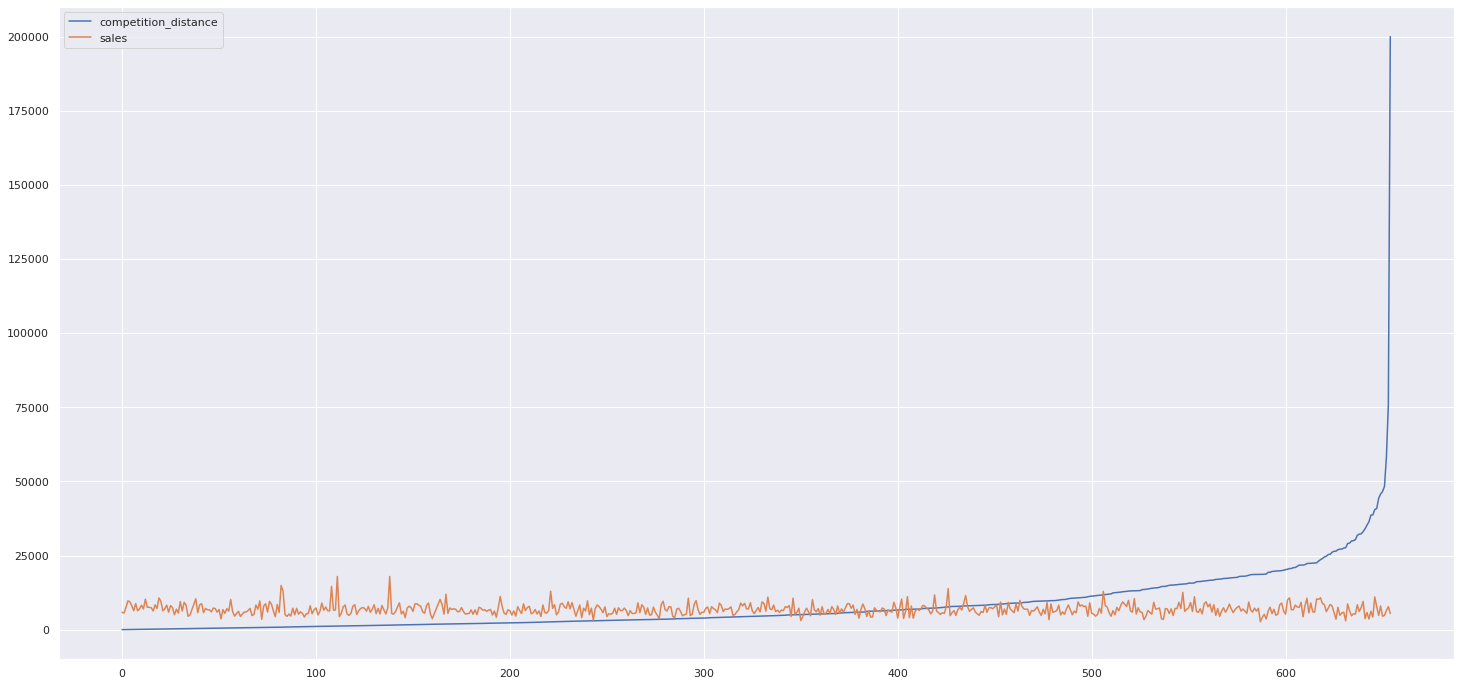

In [55]:
df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index().plot();

#####  3. It's supposed to how much more long time competitors, more sale

### 4.1. Multivariate Analysis